In [3]:
# -- クラスの手書き文字を使用したニューラルネットワーク --

import shutil
import os
from glob import glob
import random
from PIL import Image

zip_root_hand_digits = "./hand_digits.zip"
data_root_hand_digits = "./data/hand_digits"
data_root_hand_digits_tmp = f"{data_root_hand_digits}/tmp"
train_data_root = f"{data_root_hand_digits}/train"
test_data_root = f"{data_root_hand_digits}/test"

shutil.unpack_archive(zip_root_hand_digits, data_root_hand_digits_tmp)

for n in range(10):
    no_dir = f"{train_data_root}/{n}"
    os.makedirs(no_dir, exist_ok=True)

for n in range(10):
    no_dir = f"{test_data_root}/{n}"
    os.makedirs(no_dir, exist_ok=True)

my_hand_digits_images = glob(f"{data_root_hand_digits_tmp}/*.png")

for file in my_hand_digits_images:
    with Image.open(file) as img:
        for angle in range(-45, 46, 5):
            if angle:
                img_r = img.rotate(angle, fillcolor=0xffffff)
                img_r.save(file.replace('.png', f'_A{angle}.png'))

my_hand_digits_images = glob(f'{data_root_hand_digits_tmp}/**/*.png', recursive=True)

print("画像ファイル数:", len(my_hand_digits_images))
random.seed(0)
random.shuffle(my_hand_digits_images)

train_size = int(0.8 * len(my_hand_digits_images))
test_size = len(my_hand_digits_images) - train_size

for file in my_hand_digits_images[:train_size]:
    file_name = os.path.basename(file)
    label = file_name[0]
    dest_dir = f"{train_data_root}/{label}"
    shutil.move(file, f"{dest_dir}/{file_name}")

for file in my_hand_digits_images[train_size:]:
    file_name = os.path.basename(file)
    label = file_name[0]
    dest_dir = f"{test_data_root}/{label}"
    shutil.move(file, f"{dest_dir}/{file_name}")

shutil.rmtree(data_root_hand_digits_tmp)

画像ファイル数: 18962


In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_set = datasets.ImageFolder(
    root = train_data_root,
    transform = transform
)

test_set = datasets.ImageFolder(
    root = test_data_root,
    transform = transform
)

print("学習データ件数: ", len(train_set))
print("テストデータ件数: ", len(test_set))

学習データ件数:  15334
テストデータ件数:  3950


In [5]:
from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(
    train_set, 
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set,  
    batch_size = batch_size,
    shuffle = True
)

In [7]:
import torch.nn as nn

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)
        self.l3 = nn.Linear(n_hidden, n_output)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [8]:
import torch
import numpy as np

inputs, labels = next(iter(train_loader))

n_input = inputs[0].shape[0]
n_output = 10
n_hidden = 128

torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

net = Net2(
    n_input = n_input,
    n_output = n_output,
    n_hidden = n_hidden
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net.to(device)

leaning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=leaning_rate)
num_epochs = 50
history = np.zeros((0, 5))

In [17]:
from tqdm import tqdm

for epoch in range(num_epochs):
    n_train_acc, n_val_acc = 0, 0
    train_loss, val_loss = 0, 0
    n_train, n_val = 0, 0

    for inputs, labels in tqdm(train_loader):
        train_batch_size = len(labels)
        n_train += train_batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        predicted = torch.max(outputs, 1)[1]

        train_loss += loss.item() * train_batch_size
        n_train_acc += (predicted == labels).sum().item()

    for inputs_test, labels_test in test_loader:
        test_batch_size = len(labels_test)
        n_val += test_batch_size

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        outputs_test = net(inputs_test)

        loss_test = criterion(outputs_test, labels_test)

        predicted_test = torch.max(outputs_test, 1)[1]

        val_loss += loss_test.item() * test_batch_size
        n_val_acc += (predicted_test == labels_test).sum().item()

    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_val
    ave_train_loss = train_loss / n_train
    ave_val_loss = val_loss / n_val

    print (f'Epoch [{epoch + 1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} val_loss: {ave_val_loss:.5f}, val_acc: {val_acc:.5f}')

    item = np.array([epoch + 1, ave_train_loss, train_acc, ave_val_loss, val_acc])
    history = np.vstack((history, item))

100%|██████████| 154/154 [00:27<00:00,  5.62it/s]


Epoch [1/50], loss: 2.25008 acc: 0.24351 val_loss: 2.17943, val_acc: 0.33089


100%|██████████| 154/154 [00:29<00:00,  5.16it/s]


Epoch [2/50], loss: 2.04129 acc: 0.44855 val_loss: 1.86141, val_acc: 0.50329


100%|██████████| 154/154 [00:26<00:00,  5.84it/s]


Epoch [3/50], loss: 1.63495 acc: 0.55745 val_loss: 1.42598, val_acc: 0.61342


100%|██████████| 154/154 [00:26<00:00,  5.86it/s]


Epoch [4/50], loss: 1.29113 acc: 0.63649 val_loss: 1.19490, val_acc: 0.65089


100%|██████████| 154/154 [00:26<00:00,  5.75it/s]


Epoch [5/50], loss: 1.12243 acc: 0.67882 val_loss: 1.07547, val_acc: 0.68203


100%|██████████| 154/154 [00:26<00:00,  5.88it/s]


Epoch [6/50], loss: 1.03925 acc: 0.69936 val_loss: 1.00704, val_acc: 0.70911


100%|██████████| 154/154 [00:25<00:00,  6.00it/s]


Epoch [7/50], loss: 0.98781 acc: 0.70888 val_loss: 1.01286, val_acc: 0.69494


100%|██████████| 154/154 [00:25<00:00,  6.09it/s]


Epoch [8/50], loss: 0.95207 acc: 0.71938 val_loss: 0.92459, val_acc: 0.72810


100%|██████████| 154/154 [00:25<00:00,  6.10it/s]


Epoch [9/50], loss: 0.91824 acc: 0.72845 val_loss: 0.89935, val_acc: 0.73443


100%|██████████| 154/154 [00:24<00:00,  6.23it/s]


Epoch [10/50], loss: 0.88663 acc: 0.73686 val_loss: 0.86406, val_acc: 0.73924


100%|██████████| 154/154 [00:24<00:00,  6.19it/s]


Epoch [11/50], loss: 0.85477 acc: 0.74436 val_loss: 0.83223, val_acc: 0.75139


100%|██████████| 154/154 [00:24<00:00,  6.19it/s]


Epoch [12/50], loss: 0.82608 acc: 0.75310 val_loss: 0.83982, val_acc: 0.75038


100%|██████████| 154/154 [00:25<00:00,  6.16it/s]


Epoch [13/50], loss: 0.79482 acc: 0.76027 val_loss: 0.78325, val_acc: 0.76430


100%|██████████| 154/154 [00:37<00:00,  4.13it/s]


Epoch [14/50], loss: 0.76591 acc: 0.76810 val_loss: 0.75069, val_acc: 0.77291


100%|██████████| 154/154 [00:40<00:00,  3.83it/s]


Epoch [15/50], loss: 0.73445 acc: 0.77742 val_loss: 0.72769, val_acc: 0.77392


100%|██████████| 154/154 [00:39<00:00,  3.89it/s]


Epoch [16/50], loss: 0.70385 acc: 0.78720 val_loss: 0.70138, val_acc: 0.78582


100%|██████████| 154/154 [00:40<00:00,  3.82it/s]


Epoch [17/50], loss: 0.67325 acc: 0.79516 val_loss: 0.66519, val_acc: 0.79975


100%|██████████| 154/154 [00:40<00:00,  3.77it/s]


Epoch [18/50], loss: 0.64393 acc: 0.80331 val_loss: 0.64278, val_acc: 0.80076


100%|██████████| 154/154 [00:40<00:00,  3.85it/s]


Epoch [19/50], loss: 0.61308 acc: 0.81427 val_loss: 0.60773, val_acc: 0.81215


100%|██████████| 154/154 [00:39<00:00,  3.90it/s]


Epoch [20/50], loss: 0.58432 acc: 0.82359 val_loss: 0.59921, val_acc: 0.81063


100%|██████████| 154/154 [00:38<00:00,  4.02it/s]


Epoch [21/50], loss: 0.55619 acc: 0.83312 val_loss: 0.56091, val_acc: 0.82886


100%|██████████| 154/154 [00:38<00:00,  4.03it/s]


Epoch [22/50], loss: 0.52827 acc: 0.83957 val_loss: 0.53958, val_acc: 0.83494


100%|██████████| 154/154 [00:33<00:00,  4.59it/s]


Epoch [23/50], loss: 0.50359 acc: 0.84798 val_loss: 0.50777, val_acc: 0.84152


100%|██████████| 154/154 [00:47<00:00,  3.23it/s]


Epoch [24/50], loss: 0.47688 acc: 0.85829 val_loss: 0.48673, val_acc: 0.84962


100%|██████████| 154/154 [00:45<00:00,  3.42it/s]


Epoch [25/50], loss: 0.45280 acc: 0.86188 val_loss: 0.45988, val_acc: 0.86051


100%|██████████| 154/154 [00:44<00:00,  3.42it/s]


Epoch [26/50], loss: 0.42932 acc: 0.87094 val_loss: 0.45548, val_acc: 0.85772


100%|██████████| 154/154 [00:45<00:00,  3.41it/s]


Epoch [27/50], loss: 0.40927 acc: 0.87557 val_loss: 0.41832, val_acc: 0.87570


100%|██████████| 154/154 [00:45<00:00,  3.42it/s]


Epoch [28/50], loss: 0.38809 acc: 0.88392 val_loss: 0.40306, val_acc: 0.87443


100%|██████████| 154/154 [00:43<00:00,  3.54it/s]


Epoch [29/50], loss: 0.36877 acc: 0.89122 val_loss: 0.39747, val_acc: 0.87291


100%|██████████| 154/154 [00:31<00:00,  4.88it/s]


Epoch [30/50], loss: 0.35146 acc: 0.89677 val_loss: 0.37461, val_acc: 0.88380


100%|██████████| 154/154 [00:16<00:00,  9.22it/s]


Epoch [31/50], loss: 0.33197 acc: 0.90303 val_loss: 0.36019, val_acc: 0.89114


100%|██████████| 154/154 [00:15<00:00,  9.70it/s]


Epoch [32/50], loss: 0.31734 acc: 0.90948 val_loss: 0.33915, val_acc: 0.89646


100%|██████████| 154/154 [00:14<00:00, 10.42it/s]


Epoch [33/50], loss: 0.30161 acc: 0.91496 val_loss: 0.31818, val_acc: 0.90000


100%|██████████| 154/154 [00:15<00:00, 10.11it/s]


Epoch [34/50], loss: 0.28813 acc: 0.91737 val_loss: 0.32077, val_acc: 0.90025


100%|██████████| 154/154 [00:17<00:00,  9.06it/s]


Epoch [35/50], loss: 0.27298 acc: 0.92272 val_loss: 0.32230, val_acc: 0.89367


100%|██████████| 154/154 [00:13<00:00, 11.62it/s]


Epoch [36/50], loss: 0.25899 acc: 0.92761 val_loss: 0.29351, val_acc: 0.90835


100%|██████████| 154/154 [00:13<00:00, 11.39it/s]


Epoch [37/50], loss: 0.24550 acc: 0.93433 val_loss: 0.27585, val_acc: 0.91646


100%|██████████| 154/154 [00:16<00:00,  9.50it/s]


Epoch [38/50], loss: 0.23475 acc: 0.93648 val_loss: 0.25713, val_acc: 0.92076


100%|██████████| 154/154 [00:15<00:00,  9.69it/s]


Epoch [39/50], loss: 0.22420 acc: 0.94163 val_loss: 0.26387, val_acc: 0.92203


100%|██████████| 154/154 [00:15<00:00,  9.78it/s]


Epoch [40/50], loss: 0.21372 acc: 0.94418 val_loss: 0.25853, val_acc: 0.91797


100%|██████████| 154/154 [00:17<00:00,  8.92it/s]


Epoch [41/50], loss: 0.20254 acc: 0.94796 val_loss: 0.23080, val_acc: 0.93266


100%|██████████| 154/154 [00:17<00:00,  8.64it/s]


Epoch [42/50], loss: 0.19293 acc: 0.95155 val_loss: 0.23096, val_acc: 0.92835


100%|██████████| 154/154 [00:17<00:00,  8.71it/s]


Epoch [43/50], loss: 0.18459 acc: 0.95350 val_loss: 0.23516, val_acc: 0.92937


100%|██████████| 154/154 [00:20<00:00,  7.45it/s]


Epoch [44/50], loss: 0.17459 acc: 0.95859 val_loss: 0.20208, val_acc: 0.94532


100%|██████████| 154/154 [00:17<00:00,  8.69it/s]


Epoch [45/50], loss: 0.16586 acc: 0.96355 val_loss: 0.19474, val_acc: 0.94785


100%|██████████| 154/154 [00:19<00:00,  7.91it/s]


Epoch [46/50], loss: 0.15889 acc: 0.96361 val_loss: 0.19251, val_acc: 0.94481


100%|██████████| 154/154 [00:16<00:00,  9.38it/s]


Epoch [47/50], loss: 0.15214 acc: 0.96765 val_loss: 0.18357, val_acc: 0.95114


100%|██████████| 154/154 [00:14<00:00, 10.34it/s]


Epoch [48/50], loss: 0.14499 acc: 0.96935 val_loss: 0.17929, val_acc: 0.95392


100%|██████████| 154/154 [00:15<00:00, 10.26it/s]


Epoch [49/50], loss: 0.13858 acc: 0.97176 val_loss: 0.17613, val_acc: 0.95266


100%|██████████| 154/154 [00:14<00:00, 10.28it/s]


Epoch [50/50], loss: 0.13163 acc: 0.97326 val_loss: 0.16646, val_acc: 0.95772


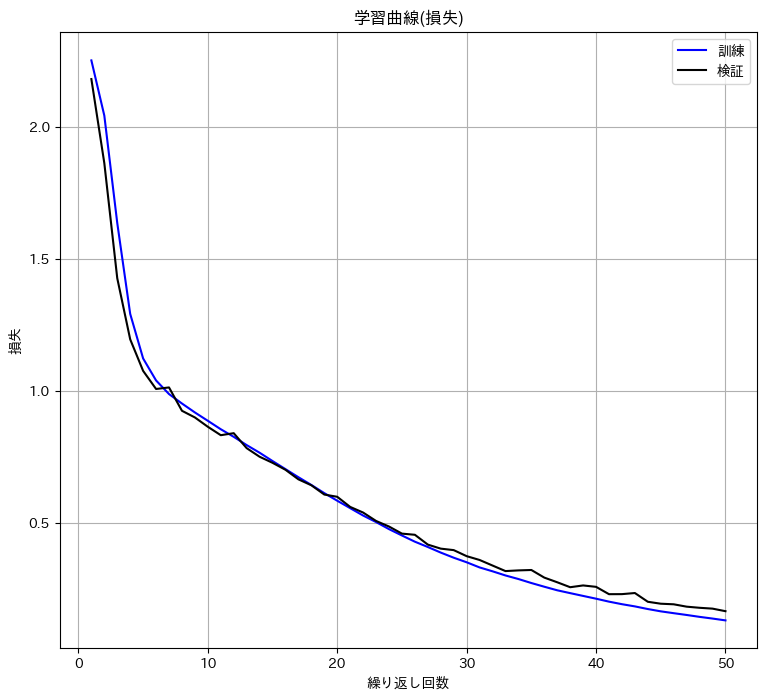

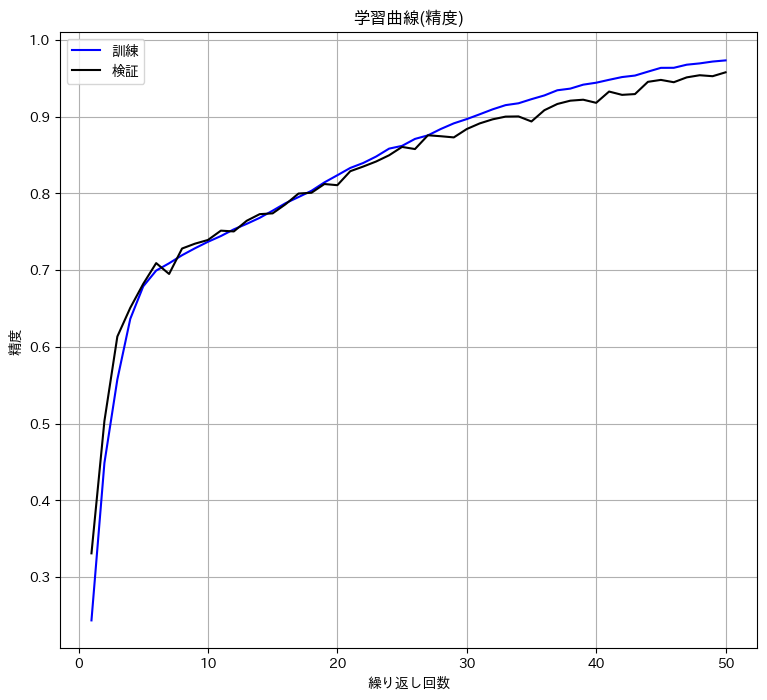

In [18]:
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid(True)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
hand_digits_model_path = "./hand_digits_only_model.pth"
torch.save(net.state_dict(), hand_digits_model_path)

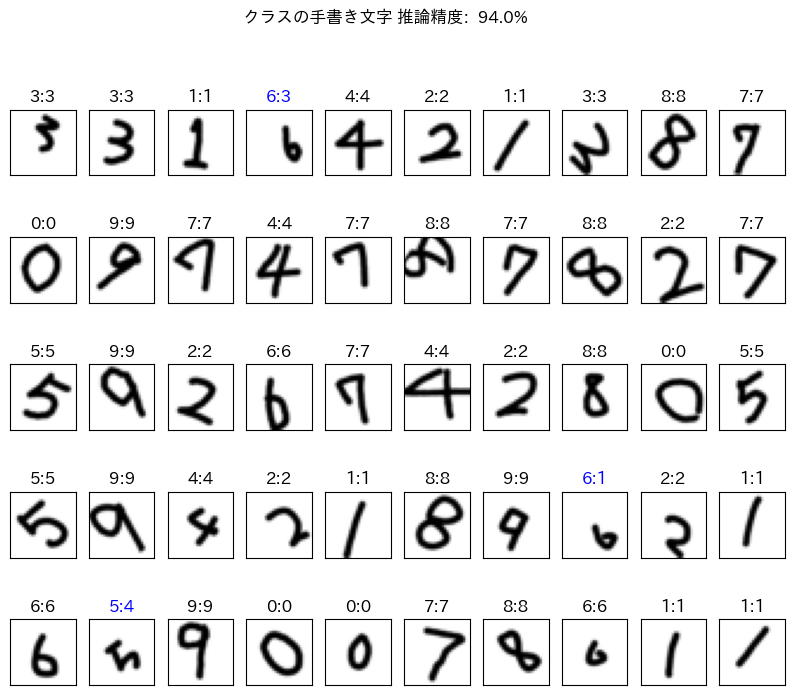

In [ ]:
inputs, labels = next(iter(test_loader))

n_input = inputs[0].shape[0]
n_output = 10
n_hidden = 128

net = Net2(
    n_input=n_input,
    n_output=n_output,
    n_hidden=n_hidden
) 
net.to(device) 
state_dict = torch.load(hand_digits_model_path, map_location=device) 
net.load_state_dict(state_dict)
net.eval()

plt.figure(figsize=(10, 8))

with torch.no_grad():
    for images, labels in test_loader:
        break

    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    predicted = torch.max(outputs, 1)[1]

    total = 0
    correct = 0

    for i in range(50):
        total += 1
        ax = plt.subplot(5, 10, i + 1)

        image = images[i]
        label = labels[i].item()
        pred = predicted[i].item()

        if (pred == label):
            c = 'k'
            correct += 1
        else:
            c = 'b'

        image2 = (image + 1)/ 2

        plt.imshow(image2.reshape(28, 28),cmap='gray')
        ax.set_title(f'{label}:{pred}', c=c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    accuracy = (correct / total) * 100
    plt.suptitle(f"クラスの手書き文字 推論精度: {accuracy: .1f}%")

In [22]:
zip_root_my_hand_digits = "./my_hand_digits.zip"
data_root_my_hand_digits = "./data/my_hand_digits"
data_root_my_hand_digits_tmp = f"{data_root_my_hand_digits}/tmp"

shutil.unpack_archive(zip_root_my_hand_digits, data_root_my_hand_digits_tmp)

for n in range(10):
    no_dir = f"{data_root_my_hand_digits}/{n}"
    os.makedirs(no_dir, exist_ok=True)

my_hand_digits_images = glob(f"{data_root_my_hand_digits_tmp}/*.png")
print("画像ファイル数:", len(my_hand_digits_images))
random.seed(0)
random.shuffle(my_hand_digits_images)

for file in my_hand_digits_images:
    file_name = os.path.basename(file)
    label = file_name[0]
    dest_dir = f"{data_root_my_hand_digits}/{label}"
    shutil.move(file, f"{dest_dir}/{file_name}")

shutil.rmtree(data_root_my_hand_digits_tmp)

画像ファイル数: 50


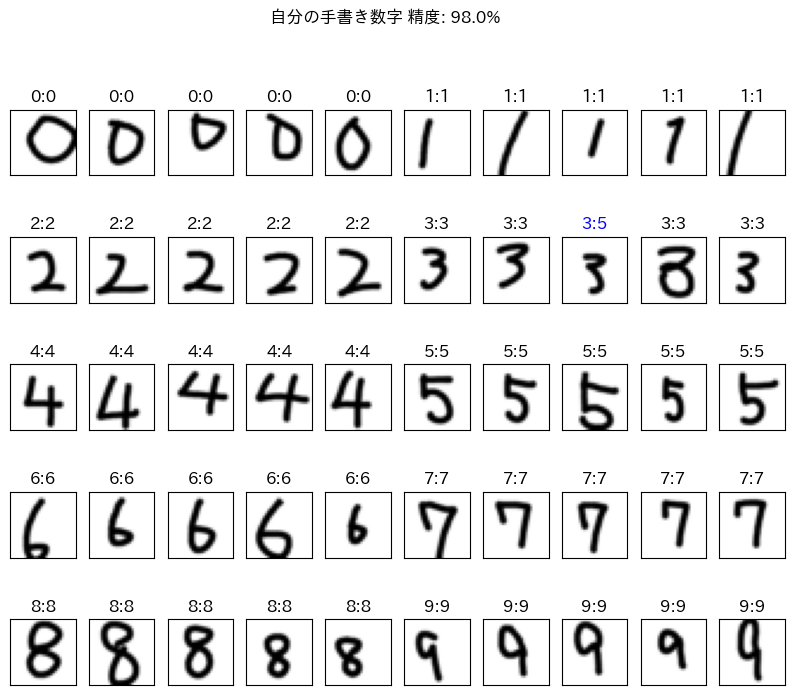

In [24]:
verify_set = datasets.ImageFolder(
    root = data_root_my_hand_digits,
    transform = transform
)

verify_loader = DataLoader(
    verify_set,
    batch_size = batch_size,
    shuffle = False
)

inputs, labels = next(iter(verify_loader))

n_input = inputs[0].numel()
n_output = 10
n_hidden = 128

net = Net2(
    n_input=n_input,
    n_output=n_output,
    n_hidden=n_hidden
) 
net.to(device) 
state_dict = torch.load(hand_digits_model_path, map_location=device) 
net.load_state_dict(state_dict)
net.eval()

plt.figure(figsize=(10, 8))

with torch.no_grad():
    for images, labels in verify_loader:
        break

    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    predicted = torch.max(outputs, 1)[1]

    total = 0
    correct = 0

    for i in range(images.size()[0]):
        total += 1
        ax = plt.subplot(5, 10, i + 1)

        image = images[i]
        label = labels[i].item()
        pred = predicted[i].item()

        if (pred == label):
            c = 'k'
            correct += 1
        else:
            c = 'b'

        image2 = (image + 1)/ 2

        plt.imshow(image2.reshape(28, 28),cmap='gray')
        ax.set_title(f'{label}:{pred}', c=c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    accuracy = (correct / total) * 100
    plt.suptitle(f'自分の手書き数字 精度: {accuracy:.1f}%')